# 1. View the data

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

# df = pd.read_csv('/home/lorbi/.cache/pypoetry/virtualenvs/av-crypto-trading-q9kMY0JF-py3.9/lib/python3.9/site-packages/dizoo/gym_anytrading/envs/data/Binance_BTCUSDT_d.csv')

df = pd.read_csv('/home/lorbi/.cache/pypoetry/virtualenvs/av-crypto-trading-q9kMY0JF-py3.9/lib/python3.9/site-packages/dizoo/gym_anytrading/envs/data/Binance_BTCUSDT_d.csv')

# df.rename(columns={'Volume BTC':'Volume'}, inplace=True)
# df['Adj Close'] = df['Close'] # :TODO why?
# df.drop(columns='Symbol', inplace=True)
# df.to_csv('/home/lorbi/Desktop/ALL-AV-BINANCE-TRADING/P-AV-Binance-Trading/venv/lib/python3.9/site-packages/dizoo/gym_anytrading/envs/data/Binance_BTCUSDT_d.csv')
print(df.head())


   Unnamed: 0           Unix        Date      Open      High       Low  \
0           0  1707436800000  2024-02-09  45288.66  48200.00  45242.12   
1           1  1707350400000  2024-02-08  44349.60  45614.30  44331.10   
2           2  1707264000000  2024-02-07  43098.96  44396.50  42788.00   
3           3  1707177600000  2024-02-06  42708.70  43399.98  42574.00   
4           4  1707091200000  2024-02-05  42582.88  43569.76  42258.10   

      Close       Volume   Volume USDT  tradecount  Adj Close  
0  47132.77  73503.48100  3.453043e+09     2323884   47132.77  
1  45288.65  45439.62231  2.042912e+09     1863650   45288.65  
2  44349.60  34392.59915  1.496014e+09     1378809   44349.60  
3  43098.95  24675.85433  1.061050e+09     1120760   43098.95  
4  42708.70  29467.75905  1.262621e+09     1317397   42708.70  


## 1.1 Random policy

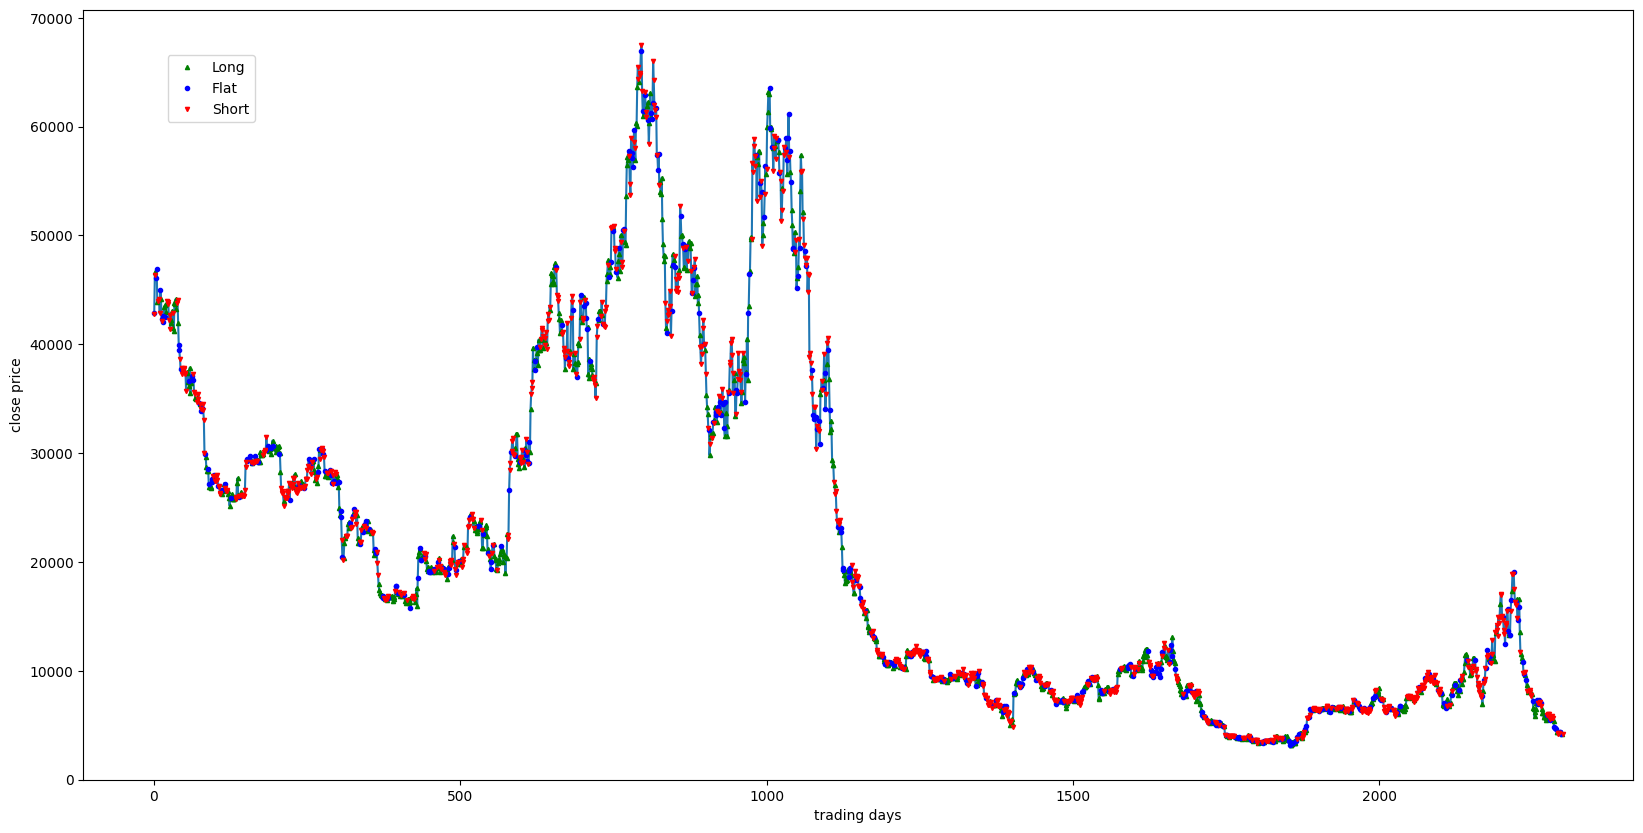

In [8]:
# Test the random policy
from easydict import EasyDict
from dizoo.gym_anytrading.envs import StocksEnv
env_cfg=dict(
    # Env number respectively for collector and evaluator.
    collector_env_num=8,
    evaluator_env_num=8,
    env_id='stocks-v0',
    n_evaluator_episode=8,
    stop_value=2,
    # num of trading days
    eps_length=2300,
    # associated with the feature length.
    window_size=20,
    # the path to save result image.
    save_path='./fig_random/',
    # the raw data file name
    stocks_data_filename='Binance_BTCUSDT_d', # name of dataset WITHOUT extension !!!! it loads .csv extension as default
    # the stocks range percentage used by train/test.
    # if one of them is None, train & test set will use all data by default.
    train_range=None,
    test_range=None,

)
env_cfg = EasyDict(env_cfg)
import pandas as pd
if __name__ == "__main__":
  env = StocksEnv(env_cfg)
  env.seed(314, dynamic_seed=False)
  done = False
  obs = env.reset()
  # The following code will randomly select 5 trading operations to change positions within 252 trading days.
  while not done:
    random_action = env.random_action()
    timestep = env.step(random_action)
    done = timestep.done
  env.render()


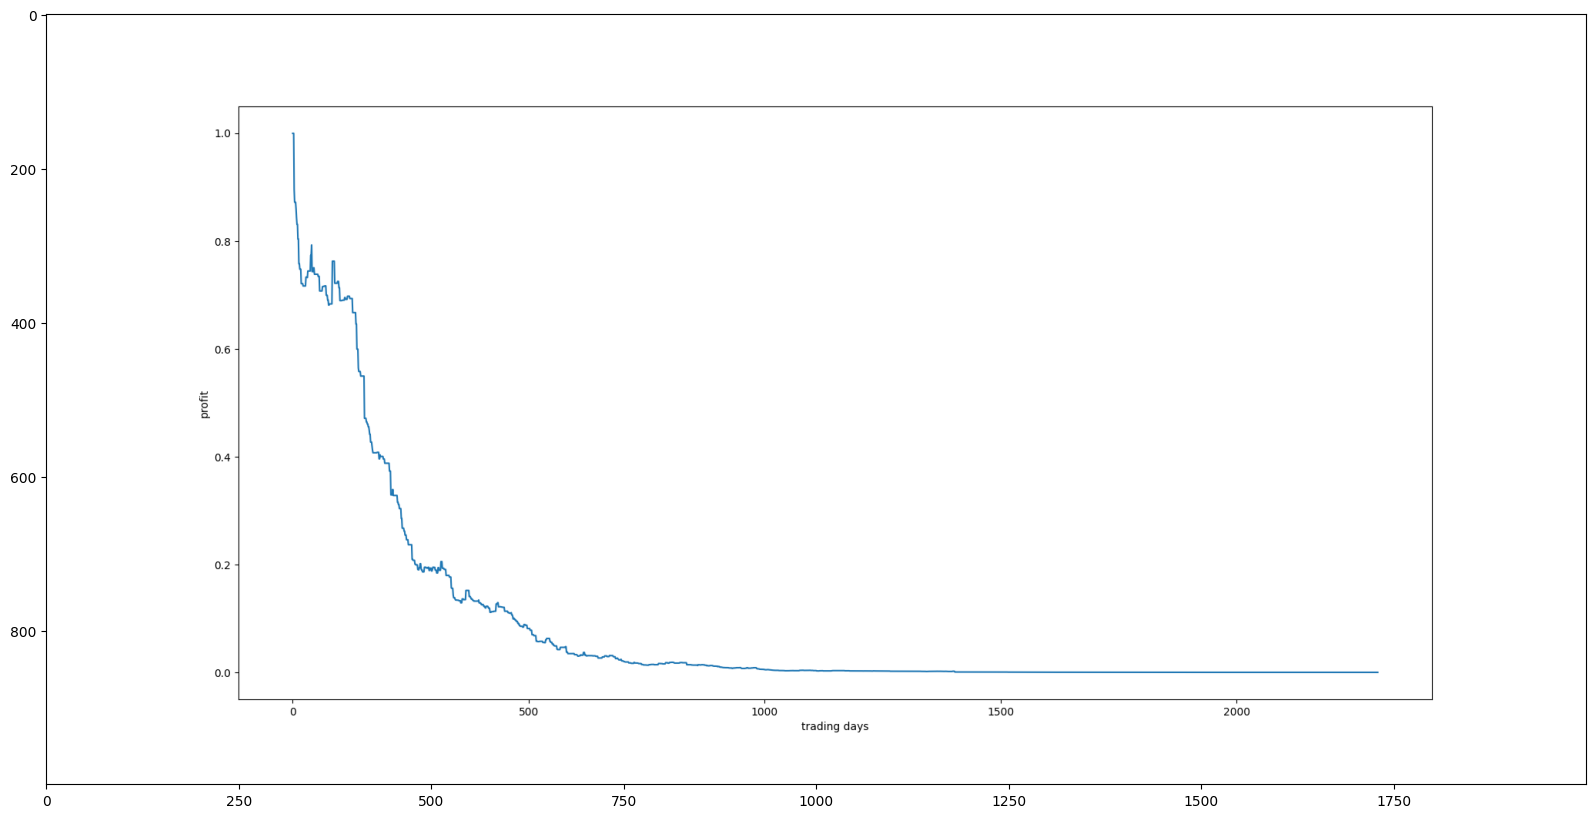

In [9]:
# Take a look at the changes in profits
import matplotlib.pyplot as plt
import matplotlib.image as img

# A line chart of Google stock's closing price changes, which marks the current strategy's positions on each trading day.
close = img.imread('./fig_random/stocks-v0-profit.png')
plt.imshow(close)

# 2. Train RL bot

In [1]:
!python train_dqn_bot.py

[06-02 20:32:12] INFO     [RANK0]: DI-engine DRL Policy      ]8;id=502373;file:///home/lorbi/.cache/pypoetry/virtualenvs/av-crypto-trading-q9kMY0JF-py3.9/lib/python3.9/site-packages/ding/worker/learner/base_learner.py\base_learner.py]8;;\:]8;id=884241;file:///home/lorbi/.cache/pypoetry/virtualenvs/av-crypto-trading-q9kMY0JF-py3.9/lib/python3.9/site-packages/ding/worker/learner/base_learner.py#338\338]8;;\
                          DQN(                                                  
                            (encoder): FCEncoder(                               
                              (act): ReLU()                                     
                              (init): Linear(in_features=62,                    
                          out_features=128, bias=True)                          
                              (main): Sequential()                              
                            )                                                   
                

# 3. Test performance

In [5]:
import torch
from easydict import EasyDict
from ding.config import compile_config
from ding.policy import DQNPolicy, single_env_forward_wrapper
from ding.model import DQN
from av_crypto_trading.reinforcement_learning.training_config import stocks_dqn_config, stocks_dqn_create_config
# from dizoo.gym_anytrading.config.stocks_dqn_config import stocks_dqn_config, stocks_dqn_create_config # default configs
# from dizoo.gym_anytrading.envs.stocks_env import StocksEnv
from av_crypto_trading.reinforcement_learning.my_stocks_env import MyStocksEnv

def main(main_config: EasyDict, create_config: EasyDict, ckpt_path: str, verbose: bool = False):
    main_config.exp_name = 'stocks_dqn_deploy'
    cfg = compile_config(main_config, create_cfg=create_config, auto=True)
    env = MyStocksEnv(cfg.env)
    model = DQN(**cfg.policy.model)
    state_dict = torch.load(ckpt_path, map_location='cpu')
    model.load_state_dict(state_dict['model'])
    policy = DQNPolicy(cfg.policy, model=model).eval_mode
    forward_fn = single_env_forward_wrapper(policy.forward)

    obs = env.reset()
    returns = 0.
    while True:
        action = forward_fn(obs)
        obs, rew, done, info = env.step(action)
        returns += rew
        
        if verbose: 
            print(f"------- \n obs: { obs}  \ndone: {done}\n  ---------------") 
            print(f"--------\n reward: {rew} \n info: {info}\n --------------")
        if done:
            break
    print(f'Deploy is finished, final epsiode return is: {returns}')


if __name__ == "__main__":
    main(stocks_dqn_config, stocks_dqn_create_config, './stocks_dqn_seed0_240522_143455/ckpt/ckpt_best.pth.tar')

Deploy is finished, final epsiode return is: [-0.88244957]


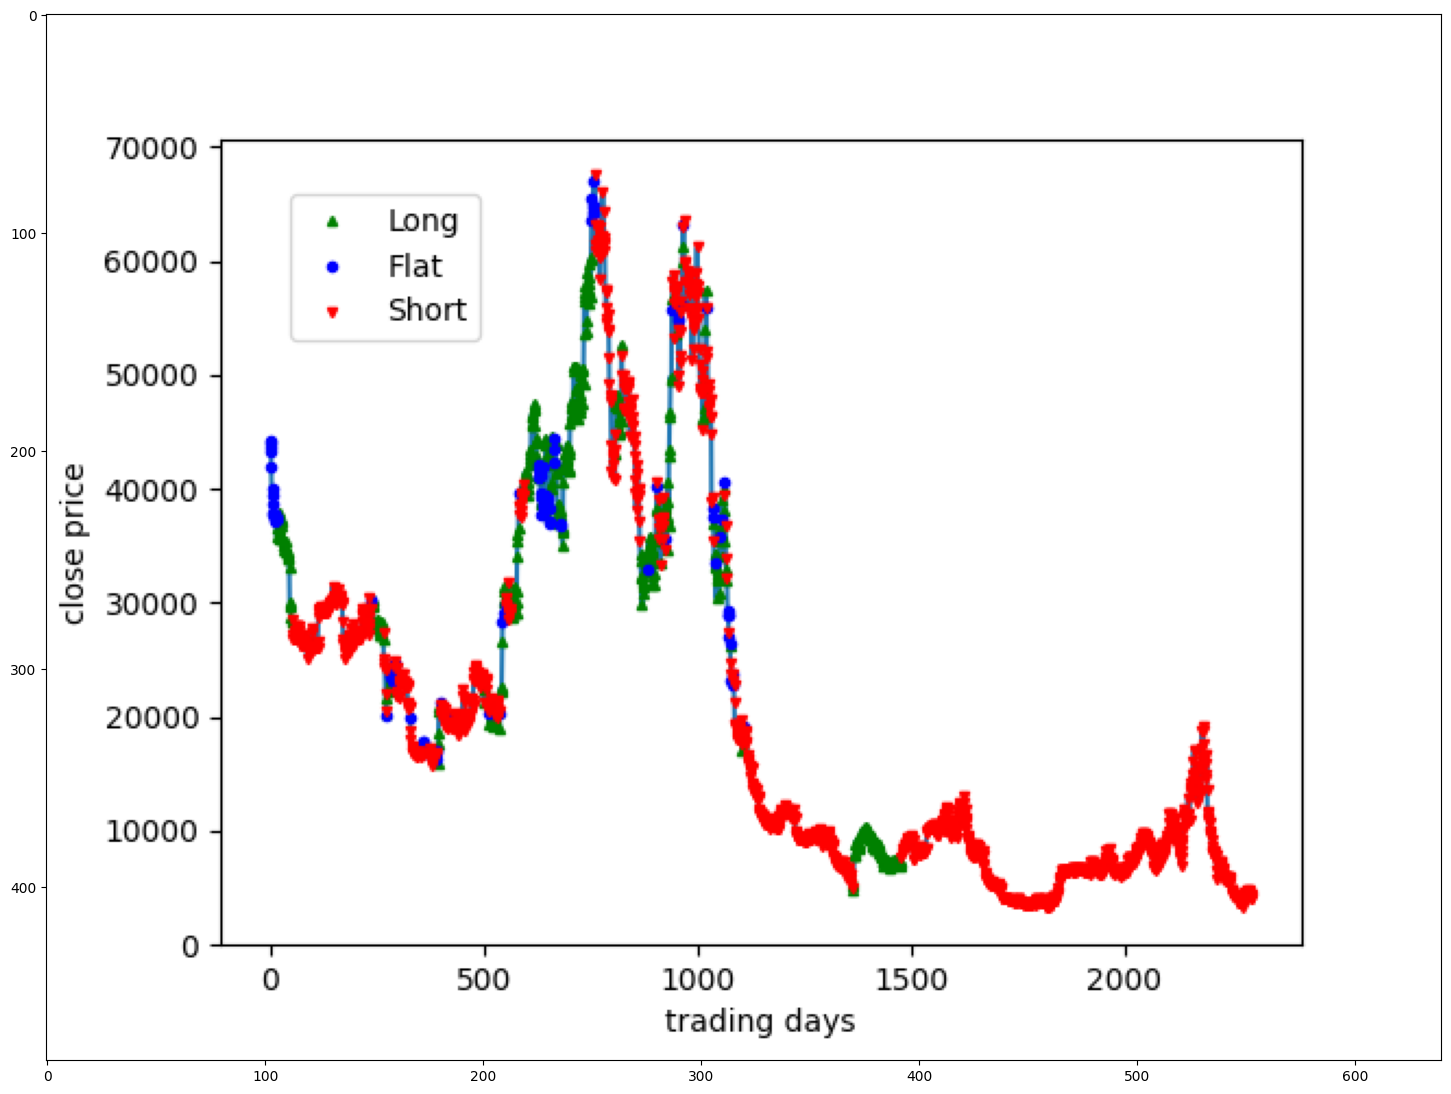

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as img

# A line chart of stock's closing price changes, which marks the current strategy's positions on each trading day.
close = img.imread('./fig/stocks-v0-2e-price.png')
plt.figure(figsize=(18, 50)) 
plt.imshow(close)

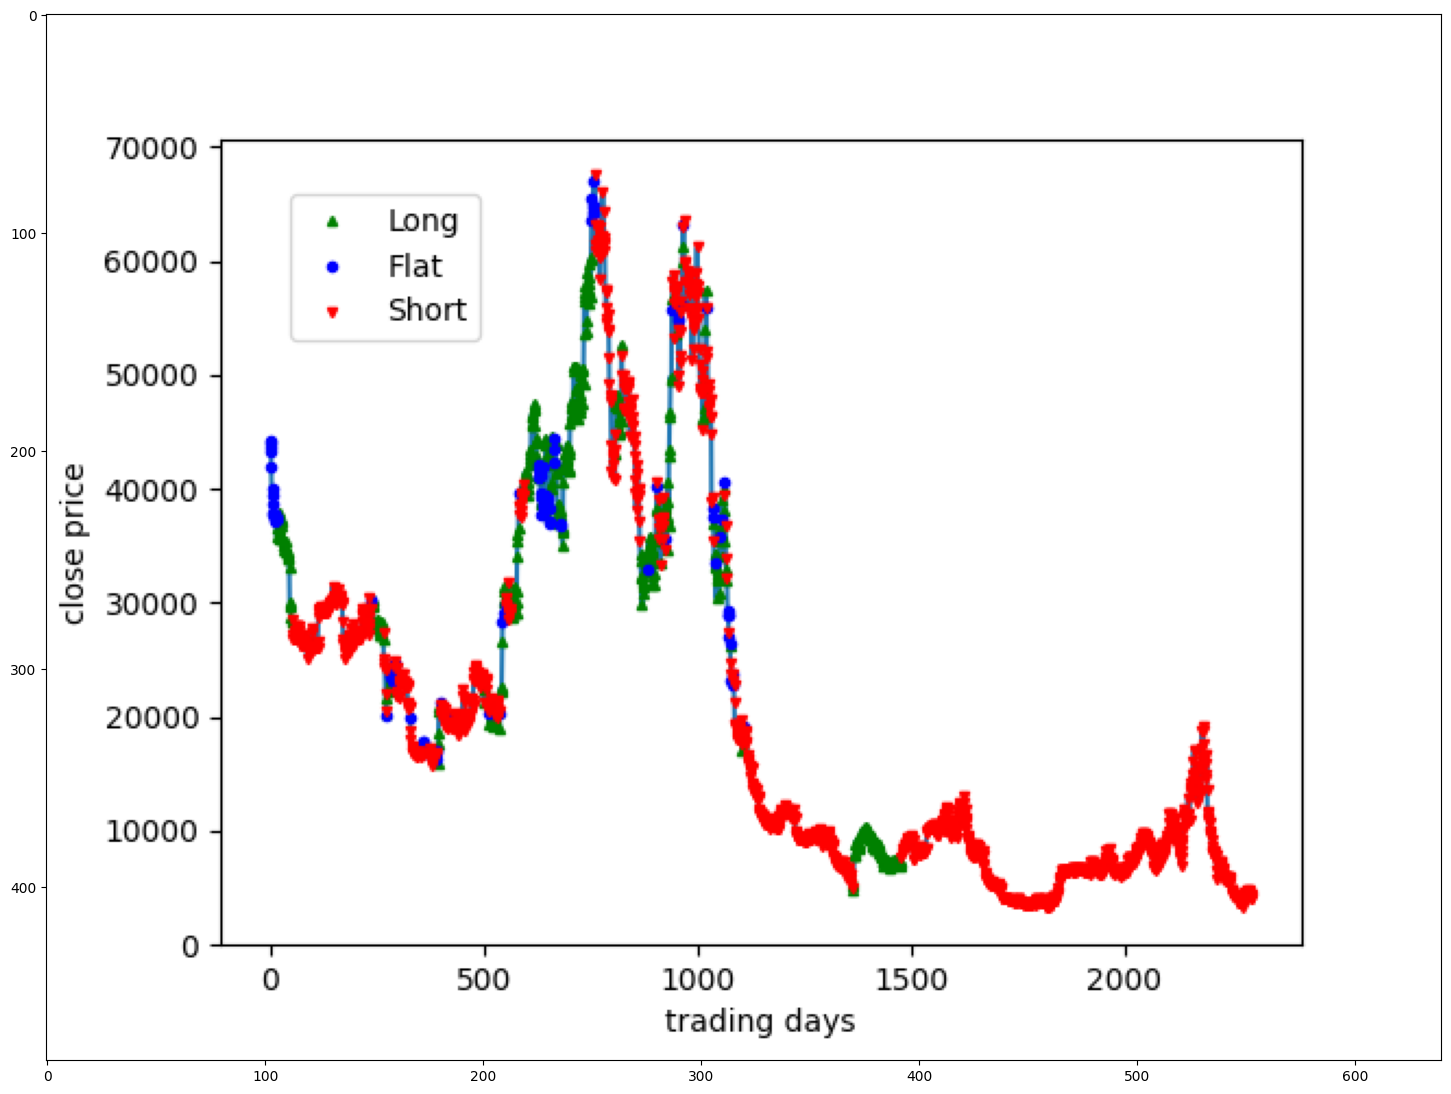

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as img

# A line chart of stock's closing price changes, which marks the current strategy's positions on each trading day.
close = img.imread('./fig/stocks-v0-2e-price.png')
plt.figure(figsize=(18, 50)) 
plt.imshow(close)

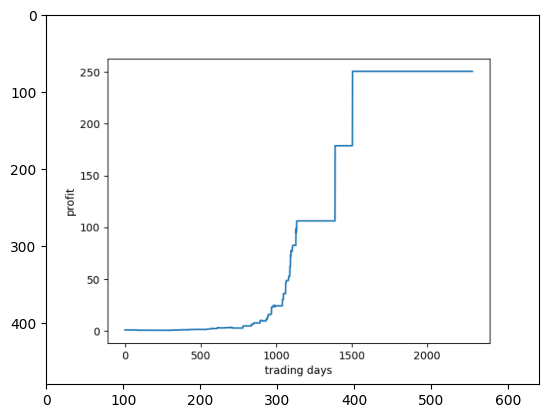

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as img


# Line chart of profits changes corresponding to the current policy
profit = img.imread('./fig/stocks-v0-3e-profit.png')
plt.imshow(profit)